# Шишкин Александр Эдуардович, группа 0391, Лабораторная работа №2
Системы с нелинейным законом управления и идентификацией параметров.

### 1. Модель системы и закон управления

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;30tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе

Сначала приведём расчет закона внутреннего управления для первого уравнения из отчёта первой лабораторной работы.

In [2]:
import sympy
#создание символьных переменных
dP=sympy.symbols('dP')
T=sympy.symbols('T')
zeta=sympy.symbols('zeta')
I=sympy.symbols('I')
dP_d=sympy.symbols('dP_d')

#запись уравнений
d_dP=17 * T + zeta - 0.1 * dP**3 + 9 * sympy.sin(4 * dP - 7) - 6
dT=-0.1 * T**3 - 2 * T * sympy.cos(5 * dP + 6) + 30 * I - 1

from sympy.solvers import solve
d_dP_d=dP_d-dP
T_d=(solve(d_dP-d_dP_d, 17*T)[0]) * (1 / 17)
print('Желаемая функция T_d(t) для эталонной модели d_dP_d = '+str(d_dP_d))
print('T_d = '+str(T_d))
print('')

Желаемая функция T_d(t) для эталонной модели d_dP_d = -dP + dP_d
T_d = 0.00588235294117647*dP**3 - 0.0588235294117647*dP + 0.0588235294117647*dP_d - 0.0588235294117647*zeta - 0.529411764705882*sin(4.0*dP - 7.0) + 0.352941176470588



Можно определить значение некотролируемого возмущения, как медианное.\
В данном случае медианное значение равно:
$\zeta_0\;=\;13.5$\
Также не учитывать $Δζ$, предположить что оно незначительно

In [5]:
psi=T_d.subs({zeta: 13.5})-T
print("psi = " + str(psi))
dpsi=sympy.diff(psi,dP)*d_dP.subs({zeta: 13.5}) + sympy.diff(psi,T)*dT
print("dpsi = " + str(dpsi))
u=solve(sympy.expand(dpsi+psi),I)
u_analytical = u[0]
print('Закон управления по методу АКАР для макропеременной psi=' + str(psi))
print('I='+str(u_analytical))
print()

psi = -T + 0.00588235294117647*dP**3 - 0.0588235294117647*dP + 0.0588235294117647*dP_d - 0.529411764705882*sin(4.0*dP - 7.0) - 0.441176470588235
dpsi = -30*I + 0.1*T**3 + 2*T*cos(5*dP + 6) + (0.0176470588235294*dP**2 - 2.11764705882353*cos(4.0*dP - 7.0) - 0.0588235294117647)*(17*T - 0.1*dP**3 + 9*sin(4*dP - 7) + 7.5) + 1
Закон управления по методу АКАР для макропеременной psi=-T + 0.00588235294117647*dP**3 - 0.0588235294117647*dP + 0.0588235294117647*dP_d - 0.529411764705882*sin(4.0*dP - 7.0) - 0.441176470588235
I=0.00333333333333333*T**3 + 0.01*T*dP**2 - 1.2*T*cos(4.0*dP - 7.0) + 0.0666666666666667*T*cos(5.0*dP + 6.0) - 0.0666666666666667*T - 5.88235294117647e-5*dP**5 + 0.00705882352941176*dP**3*cos(4.0*dP - 7.0) + 0.000392156862745098*dP**3 + 0.00529411764705882*dP**2*sin(4.0*dP - 7.0) + 0.00441176470588235*dP**2 - 0.00196078431372549*dP + 0.00196078431372549*dP_d - 0.0352941176470588*sin(4.0*dP - 7.0) - 0.317647058823529*sin(8.0*dP - 14.0) - 0.529411764705882*cos(4.0*dP - 7.0) + 0.0

Однако можно ввести интегральную компоненту для стабилизации системы, которая будет выравнивать значение при изменении некотролируемого возмущения.\
Для этого введём уравнение, которое будет описывать величину ошибки. В этом уравнении используется медианное значение $ζ_0$

Интегральная компонента

$\dot z = C3\;*\;\psi_1$\
где $\psi_1\;=\;T_d(\zeta=\zeta_0) - T$

In [6]:
C3=sympy.symbols('C3')

psi1=T_d.subs({zeta: 13.5})-T
dZ = C3*psi1
print("dz/dt = " + str(dZ))

dz/dt = C3*(-T + 0.00588235294117647*dP**3 - 0.0588235294117647*dP + 0.0588235294117647*dP_d - 0.529411764705882*sin(4.0*dP - 7.0) - 0.441176470588235)


В связи с этим вводим вторую макропеременную: $ψ_2\;=\;ψ_1\;+\;z$

$\dot P = - P^3 + dm + v(t)$

$\dot dm = -dm + G \, tanh(\omega)$


Закон управления, синтезированный по методу АКАР

$w=(-3 P^5 + 2 P^3 + 3 P^2 dm + 3 P^2 v(t) + 3 P^2 v_0 - P + Pd - dm - 2 v(t) - 2 v_0)/G$

для    $P = Pd$

Данные выражения можно получить с помощью пакета sympy


In [1]:
import sympy
from sympy.solvers import solve

P = sympy.symbols('P')
dm = sympy.symbols('dm')
G = sympy.symbols('G')
w = sympy.symbols('w')
Pd = sympy.symbols('Pd')
v0 = sympy.symbols('v0')
T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')

dP = -P**3 + dm + v0
ddm = -dm + G * w
psi_1 = P - Pd
dpsi_1 = sympy.diff(psi_1, P)*dP
dmi = solve(sympy.expand(T_1*dpsi_1 + psi_1), dm)
print(f'dm = {str(dmi[0])}')
psi_2 = dmi[0] - dm
dpsi_2 = sympy.diff(psi_2, P)*dP + sympy.diff(psi_2,dm)*ddm
u = solve(sympy.expand(T_2*dpsi_2 + psi_2), w)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'w = {str(u_analytical)}')

dm = (-P + Pd + T_1*(P**3 - v0))/T_1
psi_2 = -dm + (-P + Pd + T_1*(P**3 - v0))/T_1
w = (-P + Pd + T_1*T_2*(-3*P**5 + 3*P**2*dm + 3*P**2*v0 + dm) + T_1*(P**3 - dm - v0) + T_2*(P**3 - dm - v0))/(G*T_1*T_2)


### 2. Вспомогательные модули для моделирования


Базовый класс для моделирования контроллера

In [7]:
!pip install digicon_mod

In [8]:
import math
import numpy
import matplotlib.pyplot as plt
import digicon_mod

Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [14]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                zeta = finish_value
            else:
                zeta = init_value
            d_dP = 17*x[1] + zeta - 0.1*x[0]**3 + 9*math.sin(4*x[0] - 7) - 6
            dT = -0.1*x[1]**3 - 2*x[1]*math.cos(5*x[0] + 6) + uc - 1
            return [d_dP, dT]

        return F_internal
    return F_with_control

Вывод результатов моделирования

In [9]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')
    plt.ylim([-2.0, 2.0])
    plt.show()

###3.  Моделирование САУ с аналитическим регулятором

In [10]:
list(u_analytical.free_symbols)

[dP, T, dP_d]

In [12]:
class AKAR(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dtu):
        super(AKAR,self).__init__(gain, dtu)
        self.G=gain
        self.Pd=goal
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def control(self, x, t):
        return self.func(
            dP=x[0], T=x[1], dP_d=self.Pd
        )
        #0.00333333333333333*T**3 + 0.01*T*dP**2 - 1.2*T*cos(4.0*dP - 7.0) + 0.0666666666666667*T*cos(5.0*dP + 6.0) - 0.0666666666666667*T - 5.88235294117647e-5*dP**5 + 0.00705882352941176*dP**3*cos(4.0*dP - 7.0) + 0.000392156862745098*dP**3 + 0.00529411764705882*dP**2*sin(4.0*dP - 7.0) + 0.00441176470588235*dP**2 - 0.00196078431372549*dP + 0.00196078431372549*dP_d - 0.0352941176470588*sin(4.0*dP - 7.0) - 0.317647058823529*sin(8.0*dP - 14.0) - 0.529411764705882*cos(4.0*dP - 7.0) + 0.00392156862745098 # возвращаем последний элемент


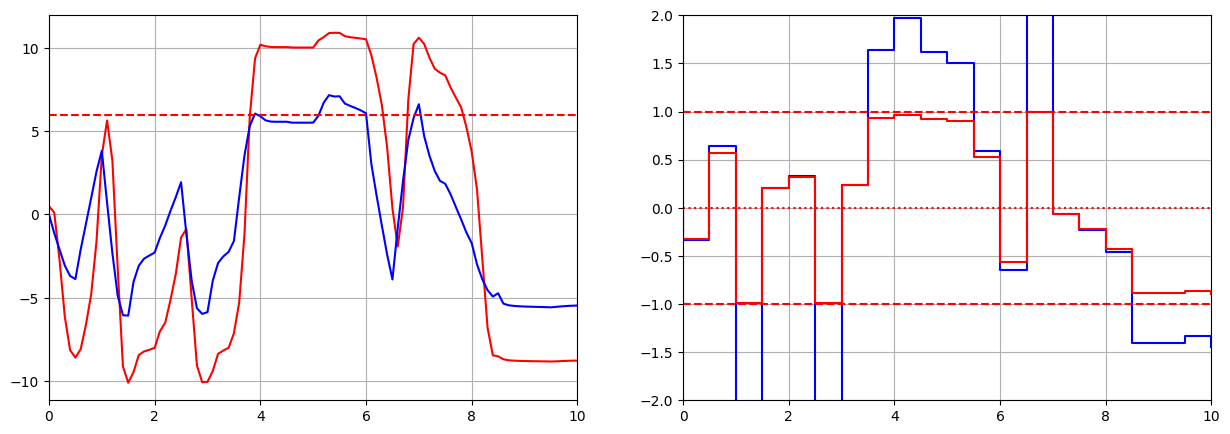

In [45]:
v0_init = 4.0
v0_finish = 23.0
change_time = 5
goal = 6
gain = 30
step = 0.5
mod_step = 0.1
tk = 10
x0 = [0.5, 0.0]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

plc = AKAR(goal=goal, gain=gain, dtu=step)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, plc)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=plc, goal=goal)

По графикам видно, что аналитический регулятор по методу АКАР не справляется с задачей управления без интегральной компоненты.

### 4. САУ с аналитическим регулятором и интегральной компонентой



Уравнения системы:

$\dot P = - \, P^3 + dm + v(t), \, v(t) \approx const$ , <br>
$\dot dm = -dm + G \, tanh(\omega)$ <br>
Функции макропеременных:

$\psi_1 = P - Pd$

$\psi_2 = \psi_1 + z = P - Pd + z$

$\psi_3 = dm_{internal} - dm$

Эталонные модели:

$T_1 \dot \psi_2 + \psi_2 = 0$

$T_3 \dot \psi_3 + \psi_3 = 0$

Интегральная компонента

$\dot z = \frac 1 {T_2} \psi_1$

Параметр $v_0$:

$v_0 = v_{min} + \frac{(v_{max}-v_{min})}{2}$

Закон внутреннего управления $dm_{internal}$:

$dm_{internal} = P^3 - \frac P {T_2} - \frac P {T_1} + \frac Pd {T_2} + \frac Pd {T_1} - v_0 - \frac z {T_1}$

Итоговый закон управления $\omega$:

$\omega = \frac 1 {G T_1 T_2 T_3}(T_1 T_2 T_3 (-3 P^5 + 3 P^2*dm + 3 P^2*v_0 + dm) + T_1 T_2 (P^3 - dm - v_0) + T_1 T_3 (P^3 - dm - v_0) + T_1 (-P + Pd) + T_2 T_3 (P^3 - dm - v0) + T_2 (-P + Pd - z) + T_3 (-P + Pd))$

при $|\omega| < 1$.


In [9]:
P = sympy.symbols('P')
dm = sympy.symbols('dm')
G = sympy.symbols('G')
w = sympy.symbols('w')
z = sympy.symbols('z')
Pd = sympy.symbols('Pd')
v0 = sympy.symbols('v0')
T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')
T_3 = sympy.symbols('T_3')

dP = -P**3 + dm + v0
ddm = -dm + G * w
psi_1 = P - Pd
dz = 1/T_2*psi_1
psi_2 = psi_1 + z
dpsi_2 = sympy.diff(psi_2, P)*dP + sympy.diff(psi_2, z)*dz
dmi = solve(sympy.expand(T_1*dpsi_2 + psi_2),dm)
print(f'dz = {dz}')
print(f'dm = {str(dmi[0])}')
psi_3 = dmi[0] - dm
dpsi_3 = sympy.diff(psi_3,P)*dP + sympy.diff(psi_3,dm)*ddm + sympy.diff(psi_3,z)*dz
u = solve(sympy.expand(T_3*dpsi_3 + psi_3),w)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'psi_3 = {str(psi_3)}')
print(f'w = {str(u_analytical)}')

dz = (P - Pd)/T_2
dm = P**3 - P/T_2 - P/T_1 + Pd/T_2 + Pd/T_1 - v0 - z/T_1
psi_2 = P - Pd + z
psi_3 = P**3 - P/T_2 - P/T_1 + Pd/T_2 + Pd/T_1 - dm - v0 - z/T_1
w = (T_1*T_2*T_3*(-3*P**5 + 3*P**2*dm + 3*P**2*v0 + dm) + T_1*T_2*(P**3 - dm - v0) + T_1*T_3*(P**3 - dm - v0) + T_1*(-P + Pd) + T_2*T_3*(P**3 - dm - v0) + T_2*(-P + Pd - z) + T_3*(-P + Pd))/(G*T_1*T_2*T_3)


Подпрограмма для реализации нелинейного регулятора с интегральной компонентой.

In [ ]:
class AKAR_i(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dt, T1, T2, T3, v0):
        super(AKAR_i,self).__init__(gain, dt)
        self.dt = dt
        self.G=gain
        self.Pd=goal
        self.T1 = T1
        self.T2 = T2
        self.T3 = T3
        self.v0 = v0
        self.z = []
        self.zt = []
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def control(self, x, t):
        P = x[0]
        dm = x[1]
        T_1 = self.T1
        T_2 = self.T2
        T_3 = self.T3
        Pd = self.Pd
        G = self.G
        v_0 = self.v0
        v0 = v_0
        dt = self.dt

        if len(self.z) < 1:
            z = 0.0
        else:
            z = self.z[-1] + dt/T_2*(P - Pd)
        self.z.append(z)
        self.zt.append(t)
        return self.func(
            G=G, T_2=T_2, P=P, v0=v0, Pd=Pd, z=z, dm=dm, T_3=T_3, T_1=T_1
        )

Моделирование и результаты.

In [ ]:
reg = AKAR_i(goal=goal, gain=gain, dt=step, T1=0.5, T2=5.0, T3=0.5, v0=1.0)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure()
plt.plot(reg.zt, reg.z, 'b-')
plt.xlim([0.0, tk])
plt.grid()
plt.show()